# Analyze Rollout Lengths - GPQA Diamond

Analyze the length of base rollouts to determine optimal `max_tokens` setting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

In [2]:
# Load data
DATA_DIR = "../rollout_outputs/gpqa"

print("Loading GPQA Diamond base rollouts...")
df_base_long = pd.read_csv(f"{DATA_DIR}/df_base_long.csv")
print(f"Loaded {len(df_base_long):,} rollouts")
print(f"Columns: {list(df_base_long.columns)}")

Loading GPQA Diamond base rollouts...
Loaded 3,720 rollouts
Columns: ['pi', 'question', 'question_no_reasoning', 'question_with_cue', 'gt_answer', 'cue_answer', 'cue_type', 'original_question', 'question_with_choices', 'condition', 'response_idx', 'model_text', 'answer', 'n_tokens', 'ĠWait_count', 'ĠWait_p']


In [3]:
# Try to use tiktoken for accurate token counting
try:
    import tiktoken
    enc = tiktoken.get_encoding("cl100k_base")
    
    print("Computing token lengths using tiktoken...")
    df_base_long['response_tokens'] = df_base_long['model_text'].apply(
        lambda x: len(enc.encode(str(x))) if pd.notna(x) else 0
    )
    print("✓ Using tiktoken for accurate token counts")
    
except ImportError:
    print("tiktoken not available, estimating from character length...")
    df_base_long['response_tokens'] = df_base_long['model_text'].apply(
        lambda x: len(str(x)) // 4 if pd.notna(x) else 0
    )
    print("⚠️  Using character-based estimation (chars / 4)")

Computing token lengths using tiktoken...
✓ Using tiktoken for accurate token counts


In [4]:
# Compute statistics
tokens = df_base_long['response_tokens']

print("=" * 70)
print("ROLLOUT LENGTH STATISTICS (in tokens)")
print("=" * 70)
print(f"Mean:     {tokens.mean():.1f}")
print(f"Median:   {tokens.median():.1f}")
print(f"Std Dev:  {tokens.std():.1f}")
print(f"Min:      {tokens.min():.0f}")
print(f"Max:      {tokens.max():.0f}")
print()
print("Percentiles:")
for p in [50, 75, 90, 95, 99, 99.5, 99.9]:
    val = np.percentile(tokens, p)
    pct_under = (tokens <= val).mean() * 100
    print(f"  {p:5.1f}th: {val:7.0f} tokens  ({pct_under:.1f}% of rollouts ≤ this)")

ROLLOUT LENGTH STATISTICS (in tokens)
Mean:     2220.4
Median:   1865.5
Std Dev:  1343.1
Min:      118
Max:      4259

Percentiles:
   50.0th:    1866 tokens  (50.0% of rollouts ≤ this)
   75.0th:    3780 tokens  (75.0% of rollouts ≤ this)
   90.0th:    4095 tokens  (90.1% of rollouts ≤ this)
   95.0th:    4096 tokens  (97.2% of rollouts ≤ this)
   99.0th:    4115 tokens  (99.2% of rollouts ≤ this)
   99.5th:    4126 tokens  (99.5% of rollouts ≤ this)
   99.9th:    4220 tokens  (99.9% of rollouts ≤ this)


In [10]:
# Current max_tokens setting
CURRENT_MAX_TOKENS = 4096  # From run_gpqa_diamond.py default

n_cutoff = (tokens > CURRENT_MAX_TOKENS).sum()
pct_cutoff = (tokens > CURRENT_MAX_TOKENS).mean() * 100

print("\n" + "=" * 70)
print(f"CUTOFF ANALYSIS (current max_tokens = {CURRENT_MAX_TOKENS})")
print("=" * 70)
print(f"Rollouts exceeding limit: {n_cutoff:,} / {len(tokens):,} ({pct_cutoff:.2f}%)")
print(f"Rollouts within limit:    {len(tokens) - n_cutoff:,} / {len(tokens):,} ({100-pct_cutoff:.2f}%)")


CUTOFF ANALYSIS (current max_tokens = 4096)
Rollouts exceeding limit: 105 / 3,720 (2.82%)
Rollouts within limit:    3,615 / 3,720 (97.18%)


In [11]:
# Recommend max_tokens for different coverage levels
print("\n" + "=" * 70)
print("RECOMMENDED max_tokens SETTINGS")
print("=" * 70)

recommendations = [
    (95, "Good balance"),
    (99, "Most rollouts"),
    (99.5, "Nearly all"),
    (99.9, "Virtually all"),
]

for percentile, desc in recommendations:
    val = int(np.percentile(tokens, percentile))
    # Round up to nearest 256
    recommended = ((val + 255) // 256) * 256
    n_covered = (tokens <= recommended).sum()
    pct_covered = (tokens <= recommended).mean() * 100
    print(f"{percentile:5.1f}th percentile ({desc:15s}): max_tokens = {recommended:5,} (covers {pct_covered:.2f}%)")


RECOMMENDED max_tokens SETTINGS
 95.0th percentile (Good balance   ): max_tokens = 4,096 (covers 97.18%)
 99.0th percentile (Most rollouts  ): max_tokens = 4,352 (covers 100.00%)
 99.5th percentile (Nearly all     ): max_tokens = 4,352 (covers 100.00%)
 99.9th percentile (Virtually all  ): max_tokens = 4,352 (covers 100.00%)


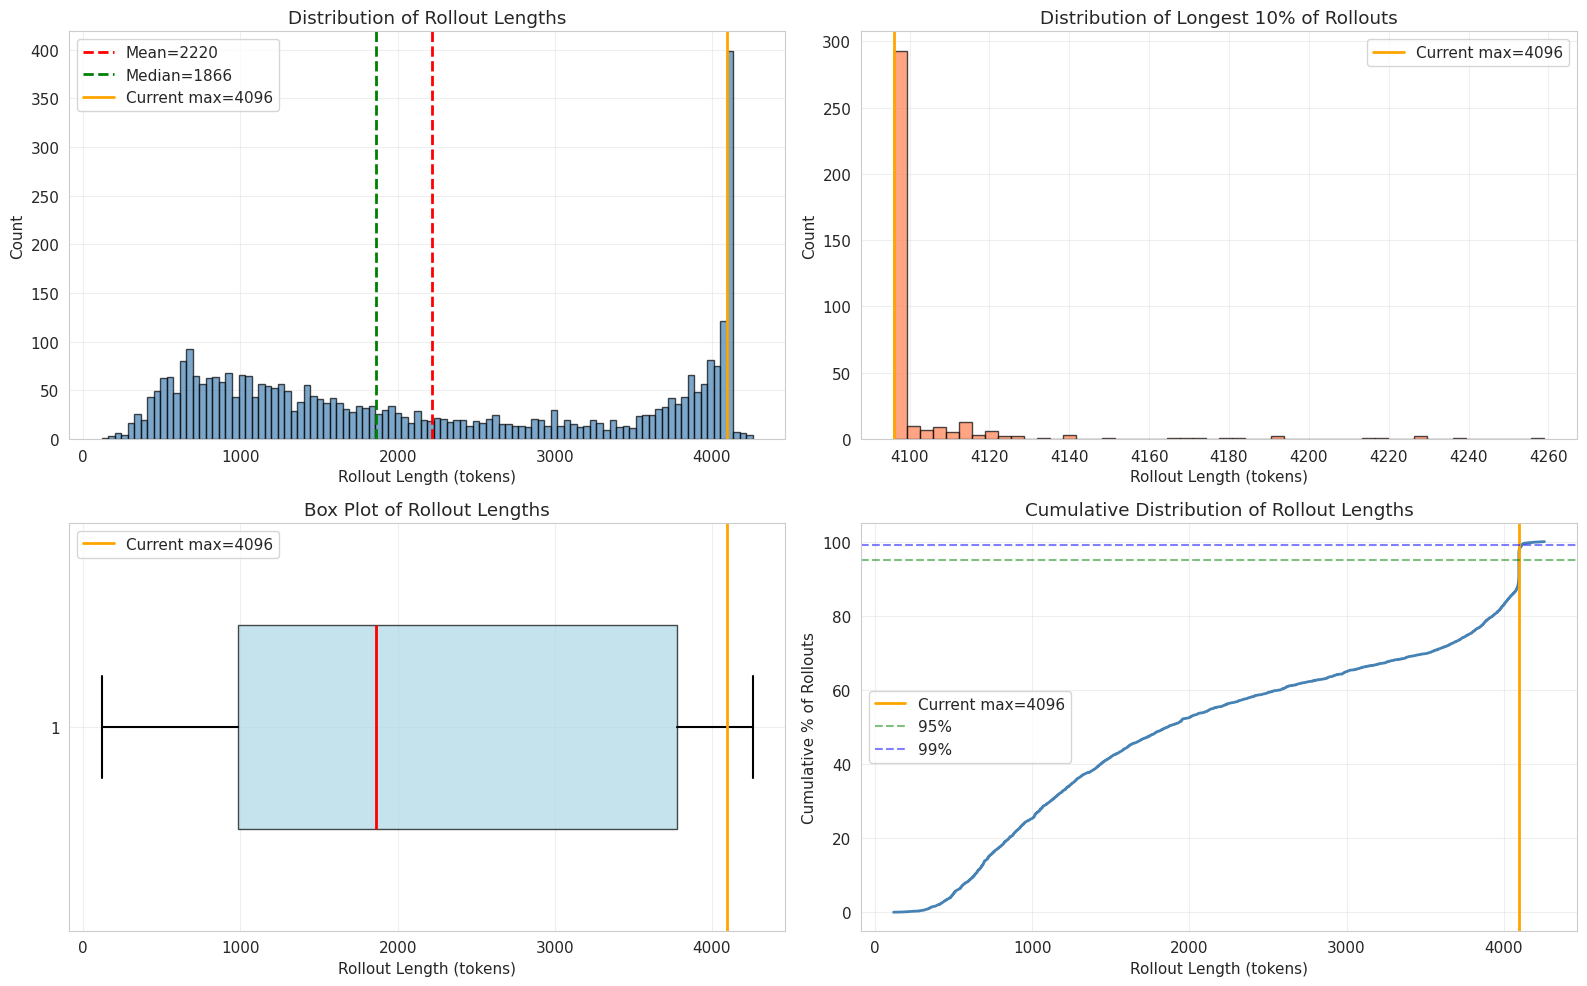

In [12]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Histogram of all rollout lengths
axes[0, 0].hist(tokens, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=tokens.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={tokens.mean():.0f}')
axes[0, 0].axvline(x=tokens.median(), color='green', linestyle='--', linewidth=2, label=f'Median={tokens.median():.0f}')
axes[0, 0].axvline(x=CURRENT_MAX_TOKENS, color='orange', linestyle='-', linewidth=2, label=f'Current max={CURRENT_MAX_TOKENS}')
axes[0, 0].set_xlabel('Rollout Length (tokens)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Rollout Lengths')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Zoomed in on high end
high_tokens = tokens[tokens > tokens.quantile(0.9)]
axes[0, 1].hist(high_tokens, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=CURRENT_MAX_TOKENS, color='orange', linestyle='-', linewidth=2, label=f'Current max={CURRENT_MAX_TOKENS}')
axes[0, 1].set_xlabel('Rollout Length (tokens)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution of Longest 10% of Rollouts')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Box plot
bp = axes[1, 0].boxplot([tokens], vert=False, widths=0.5, patch_artist=True,
                         boxprops=dict(facecolor='lightblue', alpha=0.7),
                         medianprops=dict(color='red', linewidth=2),
                         whiskerprops=dict(linewidth=1.5),
                         capprops=dict(linewidth=1.5))
axes[1, 0].axvline(x=CURRENT_MAX_TOKENS, color='orange', linestyle='-', linewidth=2, label=f'Current max={CURRENT_MAX_TOKENS}')
axes[1, 0].set_xlabel('Rollout Length (tokens)')
axes[1, 0].set_title('Box Plot of Rollout Lengths')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Cumulative distribution
sorted_tokens = np.sort(tokens)
cumulative = np.arange(1, len(sorted_tokens) + 1) / len(sorted_tokens) * 100
axes[1, 1].plot(sorted_tokens, cumulative, color='steelblue', linewidth=2)
axes[1, 1].axvline(x=CURRENT_MAX_TOKENS, color='orange', linestyle='-', linewidth=2, label=f'Current max={CURRENT_MAX_TOKENS}')
axes[1, 1].axhline(y=95, color='green', linestyle='--', alpha=0.5, label='95%')
axes[1, 1].axhline(y=99, color='blue', linestyle='--', alpha=0.5, label='99%')
axes[1, 1].set_xlabel('Rollout Length (tokens)')
axes[1, 1].set_ylabel('Cumulative % of Rollouts')
axes[1, 1].set_title('Cumulative Distribution of Rollout Lengths')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Show some examples of the longest rollouts
print("=" * 70)
print("EXAMPLES OF LONGEST ROLLOUTS")
print("=" * 70)

longest = df_base_long.nlargest(5, 'response_tokens')
for idx, row in longest.iterrows():
    print(f"\nProblem {row['pi']}, Response {row['response_idx']}:")
    print(f"  Tokens: {row['response_tokens']:,}")
    print(f"  Answer: {row['answer']}")
    print(f"  Text preview (first 200 chars): {str(row['model_text'])[:200]}...")
    print("-" * 70)

EXAMPLES OF LONGEST ROLLOUTS

Problem 176, Response 6:
  Tokens: 4,259
  Answer: nan
  Text preview (first 200 chars): Okay, so I have this quantum mechanics problem here, and I'm a bit confused, but I'll try to work through it step by step. Let's see what the problem is asking.

The state of the system at time t is g...
----------------------------------------------------------------------

Problem 176, Response 10:
  Tokens: 4,238
  Answer: nan
  Text preview (first 200 chars): Alright, so I'm trying to figure out this quantum mechanics problem. Let me start by understanding what's given and what's being asked.

The system's state at time t is given as a column matrix with e...
----------------------------------------------------------------------

Problem 174, Response 17:
  Tokens: 4,229
  Answer: nan
  Text preview (first 200 chars): Okay, so I have this problem where an electron is in a spin state given as (3i, 4). I need to find the expectation value of its spin along the y-dire


NULL vs NON-NULL ANSWER ROLLOUT LENGTHS
Null answers:     950 rollouts, mean length = 3955 tokens
Non-null answers: 2,770 rollouts, mean length = 1625 tokens

Difference: 2330 tokens


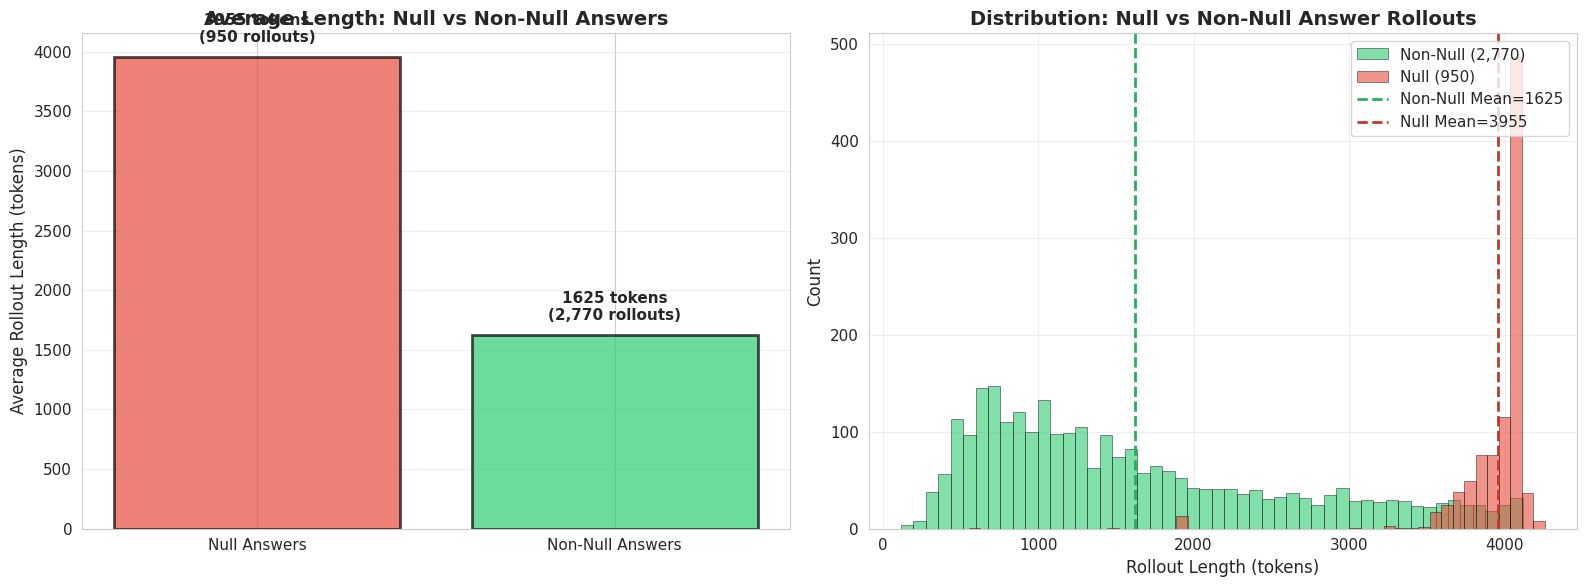


DETAILED STATISTICS

Null Answer Rollouts:
  Count:    950
  Mean:     3955.4 tokens
  Median:   4073.0 tokens
  Std Dev:  314.8 tokens
  Min:      555 tokens
  Max:      4259 tokens

Non-Null Answer Rollouts:
  Count:    2,770
  Mean:     1625.3 tokens
  Median:   1331.0 tokens
  Std Dev:  1001.0 tokens
  Min:      118 tokens
  Max:      4116 tokens


In [13]:
# Compare average length of null vs non-null answer rollouts
print("\n" + "=" * 70)
print("NULL vs NON-NULL ANSWER ROLLOUT LENGTHS")
print("=" * 70)

df_null = df_base_long[df_base_long['answer'].isna()]
df_non_null = df_base_long[df_base_long['answer'].notna()]

print(f"Null answers:     {len(df_null):,} rollouts, mean length = {df_null['response_tokens'].mean():.0f} tokens")
print(f"Non-null answers: {len(df_non_null):,} rollouts, mean length = {df_non_null['response_tokens'].mean():.0f} tokens")
print(f"\nDifference: {df_null['response_tokens'].mean() - df_non_null['response_tokens'].mean():.0f} tokens")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Bar chart comparison
categories = ['Null Answers', 'Non-Null Answers']
means = [df_null['response_tokens'].mean(), df_non_null['response_tokens'].mean()]
counts = [len(df_null), len(df_non_null)]

axes[0].bar(categories, means, color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Average Rollout Length (tokens)', fontsize=12)
axes[0].set_title('Average Length: Null vs Non-Null Answers', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (cat, mean, count) in enumerate(zip(categories, means, counts)):
    axes[0].text(i, mean + 100, f'{mean:.0f} tokens\n({count:,} rollouts)', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Overlapping histograms
axes[1].hist(df_non_null['response_tokens'], bins=50, color='#2ecc71', alpha=0.6, 
            label=f'Non-Null ({len(df_non_null):,})', edgecolor='black', linewidth=0.5)
axes[1].hist(df_null['response_tokens'], bins=50, color='#e74c3c', alpha=0.6, 
            label=f'Null ({len(df_null):,})', edgecolor='black', linewidth=0.5)
axes[1].axvline(x=df_non_null['response_tokens'].mean(), color='#27ae60', linestyle='--', 
               linewidth=2, label=f'Non-Null Mean={df_non_null["response_tokens"].mean():.0f}')
axes[1].axvline(x=df_null['response_tokens'].mean(), color='#c0392b', linestyle='--', 
               linewidth=2, label=f'Null Mean={df_null["response_tokens"].mean():.0f}')
axes[1].set_xlabel('Rollout Length (tokens)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Distribution: Null vs Non-Null Answer Rollouts', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary
print("\n" + "=" * 70)
print("DETAILED STATISTICS")
print("=" * 70)
print("\nNull Answer Rollouts:")
print(f"  Count:    {len(df_null):,}")
print(f"  Mean:     {df_null['response_tokens'].mean():.1f} tokens")
print(f"  Median:   {df_null['response_tokens'].median():.1f} tokens")
print(f"  Std Dev:  {df_null['response_tokens'].std():.1f} tokens")
print(f"  Min:      {df_null['response_tokens'].min():.0f} tokens")
print(f"  Max:      {df_null['response_tokens'].max():.0f} tokens")

print("\nNon-Null Answer Rollouts:")
print(f"  Count:    {len(df_non_null):,}")
print(f"  Mean:     {df_non_null['response_tokens'].mean():.1f} tokens")
print(f"  Median:   {df_non_null['response_tokens'].median():.1f} tokens")
print(f"  Std Dev:  {df_non_null['response_tokens'].std():.1f} tokens")
print(f"  Min:      {df_non_null['response_tokens'].min():.0f} tokens")
print(f"  Max:      {df_non_null['response_tokens'].max():.0f} tokens")


In [ ]:
# Check if long rollouts have valid answers
print("\n" + "=" * 70)
print("ANSWER QUALITY BY LENGTH")
print("=" * 70)

# Bin by length
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 10000]
labels = ['0-500', '500-1k', '1-1.5k', '1.5-2k', '2-2.5k', '2.5-3k', '3k+']
df_base_long['length_bin'] = pd.cut(df_base_long['response_tokens'], bins=bins, labels=labels)

# Compute null rate by bin
for label in labels:
    bin_data = df_base_long[df_base_long['length_bin'] == label]
    if len(bin_data) > 0:
        null_rate = bin_data['answer'].isna().mean() * 100
        print(f"  {label:10s}: {len(bin_data):5,} rollouts, {null_rate:5.1f}% null answers")


ANSWER QUALITY BY LENGTH
  0-500     :   186 rollouts,   0.0% null answers
  500-1k    :   756 rollouts,   0.1% null answers
  1-1.5k    :   618 rollouts,   0.2% null answers
  1.5-2k    :   394 rollouts,   3.3% null answers
  2-2.5k    :   251 rollouts,   0.0% null answers
  2.5-3k    :   210 rollouts,   0.0% null answers
  3k+       : 1,305 rollouts,  71.6% null answers
